##      **Wound Classification Using DL**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Wound dataset" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d yasinpratomo/wound-dataset
!unzip wound-dataset.zip -d wound-dataset1

Dataset URL: https://www.kaggle.com/datasets/yasinpratomo/wound-dataset
License(s): unknown
 36% 5.00M/13.9M [00:00<00:00, 49.4MB/s]
100% 13.9M/13.9M [00:00<00:00, 81.4MB/s]
Archive:  wound-dataset.zip
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (1).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (10).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (11).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (12).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (13).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (14).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (15).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (16).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (17).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (18).jpg  
  inflating: wound-dataset1/Wound_dataset/Abrasions/abrasions (19).jp

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv  and test_data.csv file with columns image_path and label for further processing:-


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Directories for train and validation datasets
train_dir = '/content/wound-dataset1/Wound_dataset'

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Function to process each directory (train or valid)
def process_directory(directory, label_list, path_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):
                    image_path = os.path.join(label_dir, image_name)
                    path_list.append(image_path)
                    label_list.append(label)

# Process the train and valid directories
process_directory(train_dir, labels, image_paths)

# Create DataFrame
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.02, random_state=42)

# Set "Label" column for test data to "Unknown"
test_df['Label'] = 'Unknown'

# Save to CSV
train_csv_path = '/content/wound-dataset1/train_data.csv'
test_csv_path = '/content/wound-dataset1/test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("CSV files for train and test data saved successfully!")

CSV files for train and test data saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , InceptionV3 and ResNet50V2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception  , DenseNet121 , MobileNetV2 , ResNet50V2  , InceptionV3
from keras import layers, models, optimizers

# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/content/wound-dataset1/train_data.csv')

# Initial split with stratification
train_df, val_df = train_test_split(df, train_size=0.94, test_size=0.06, random_state=42, stratify=df['Label'])

# Number of unique classes
num_classes = len(df['Label'].unique())
print("Number of unique classes:", num_classes)

# Ensure both train and validation sets have equal number of labels
def stratified_split(df, stratify_colname, frac_train=0.95, frac_val=0.05, random_state=None):
    # Splitting data
    train_df, val_df = train_test_split(df, train_size=frac_train, test_size=frac_val, random_state=random_state, stratify=df[stratify_colname])
    return train_df, val_df

# Perform stratified split again to ensure equal distribution of labels
train_df, val_df = stratified_split(df, 'Label', frac_train=0.95, frac_val=0.05, random_state=42)

# Verify the distribution of labels in the split dataframes
print("Training set label distribution:")
print(train_df['Label'].value_counts())
print("\nValidation set label distribution:")
print(val_df['Label'].value_counts())

Number of unique classes: 7
Training set label distribution:
Label
Bruises          115
Abrasions         78
Laceration        57
Burns             54
Cut               46
Ingrown_nails     28
Stab_wound        22
Name: count, dtype: int64

Validation set label distribution:
Label
Bruises          6
Abrasions        4
Burns            3
Cut              3
Laceration       3
Ingrown_nails    2
Stab_wound       1
Name: count, dtype: int64


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

In [7]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 400 validated image filenames belonging to 7 classes.
Found 22 validated image filenames belonging to 7 classes.


# Exploratory Data Analysis

In [8]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                            Image_Path      Label
217  /content/wound-dataset1/Wound_dataset/Bruises/...    Bruises
56   /content/wound-dataset1/Wound_dataset/Burns/bu...      Burns
171  /content/wound-dataset1/Wound_dataset/Abrasion...  Abrasions
3    /content/wound-dataset1/Wound_dataset/Bruises/...    Bruises
318  /content/wound-dataset1/Wound_dataset/Abrasion...  Abrasions
(400, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 217 to 177
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  400 non-null    object
 1   Label       400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB
None
                                               Image_Path    Label
count                                                 400      400
unique                                                400        7
top     /content/wound-dataset1/Wound_dataset/Bruises/...  Bruises
freq                 

## Bar - Chart
 A bar chart showing the distribution of labels in the training dataset. It visually represents the frequency of each label category, providing an overview of how the labels are distributed across the dataset.

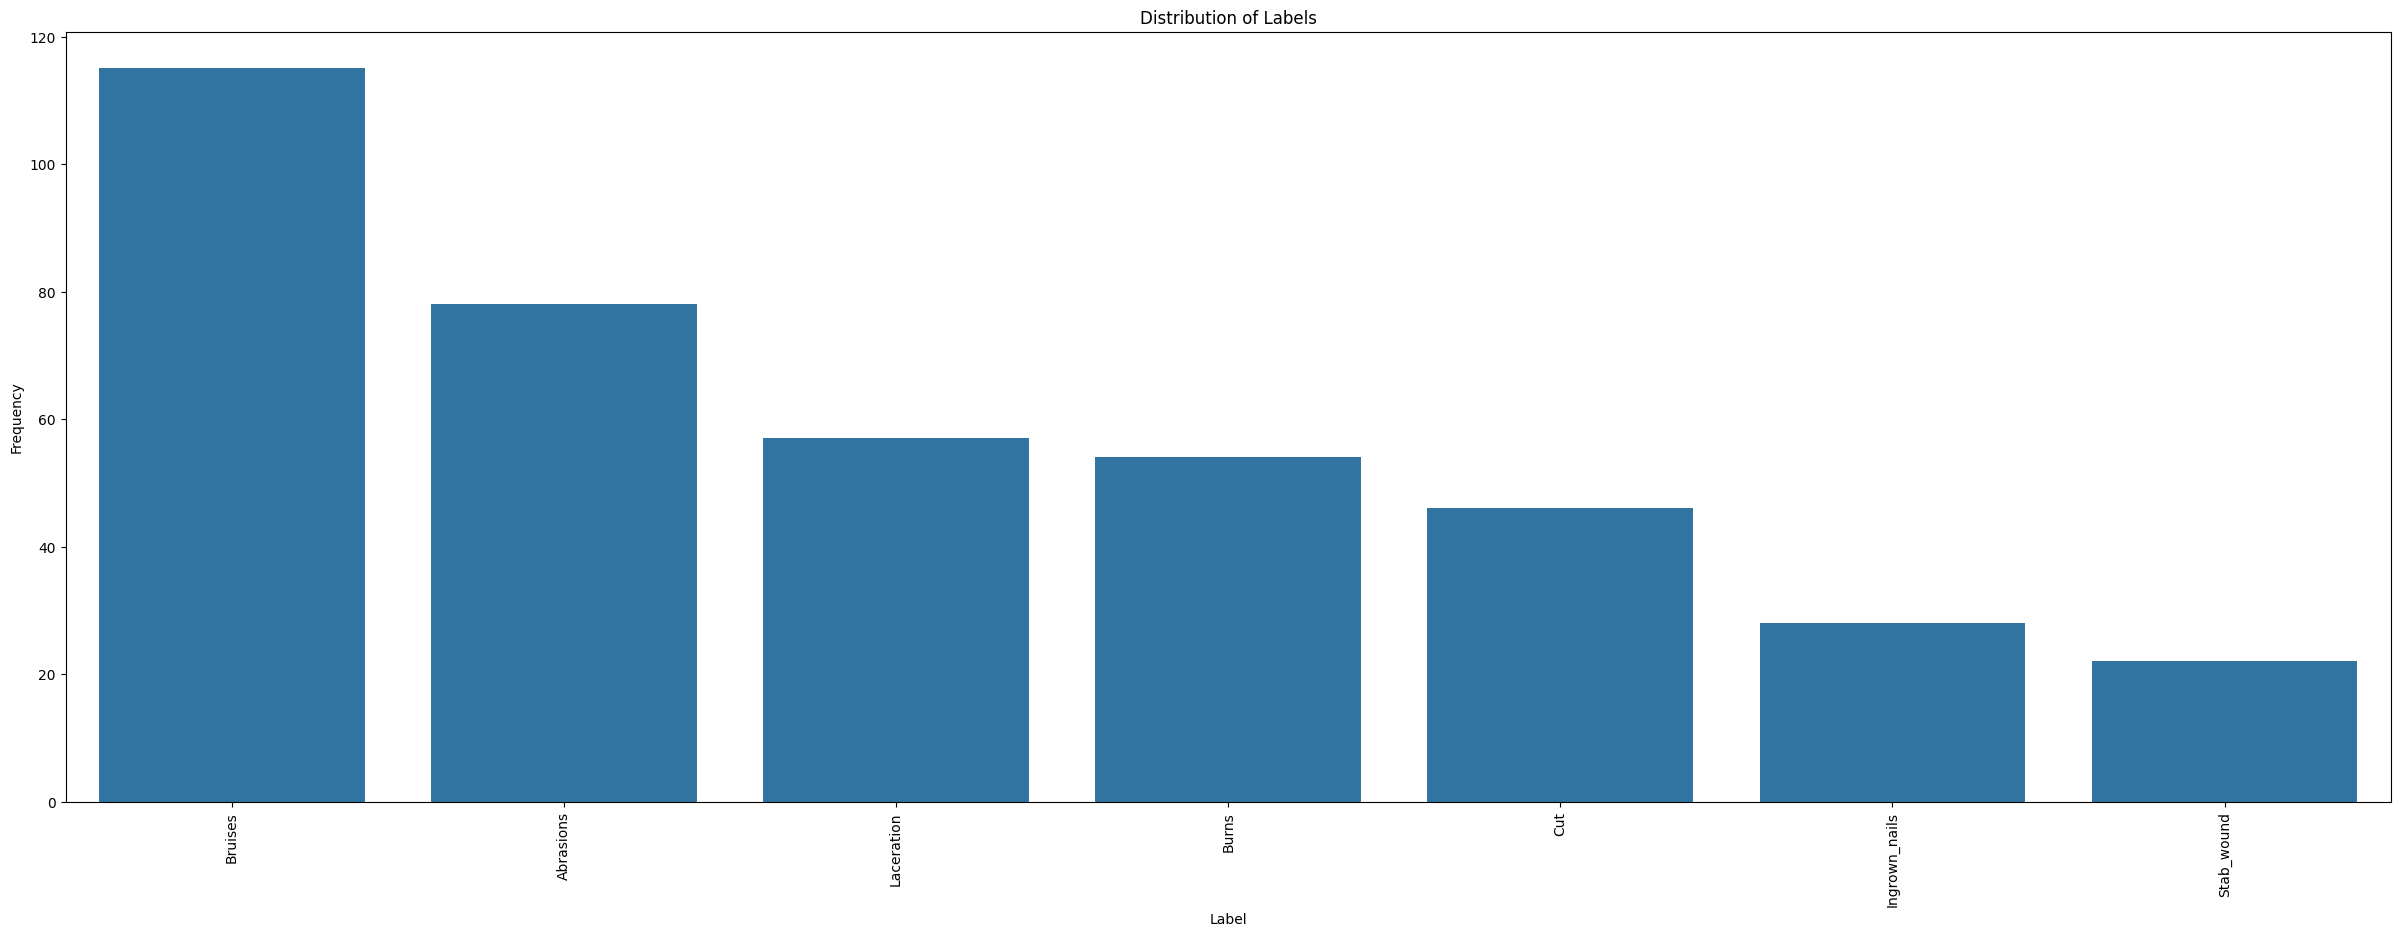

In [9]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

## Pie Chart :-
A pie chart illustrating the distribution of labels in the training dataset. The percentage value displayed on each segment indicates the relative frequency of each label category.

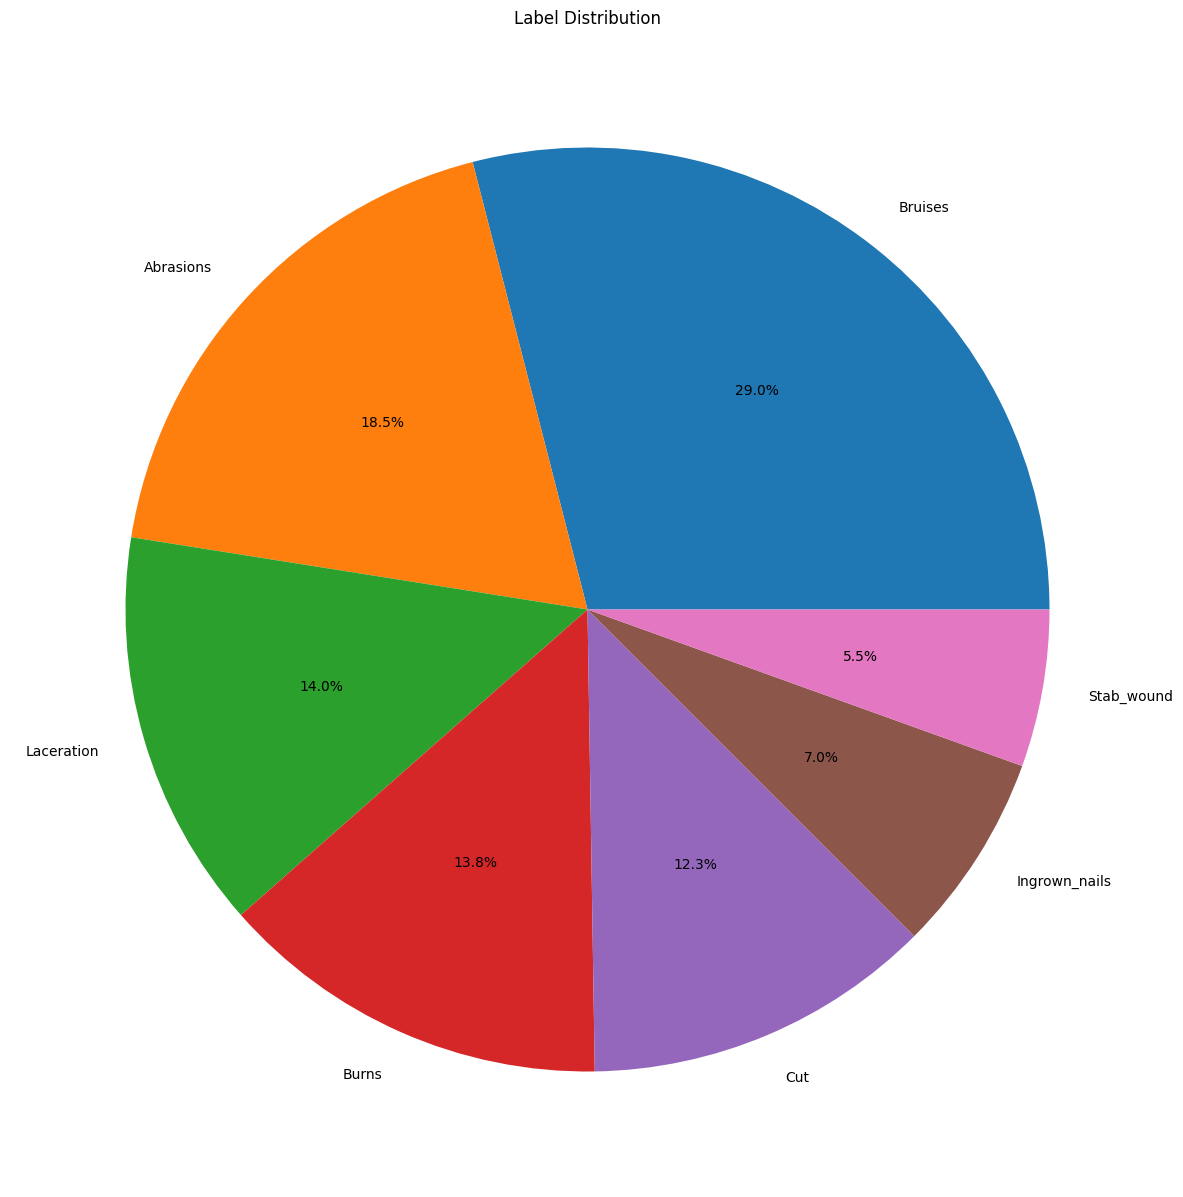

In [ ]:
# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

## Image paths distribution :-
 Visualizes the distribution of top 20 image paths by label, displays unique values in categorical columns.

Number of unique image paths: 400


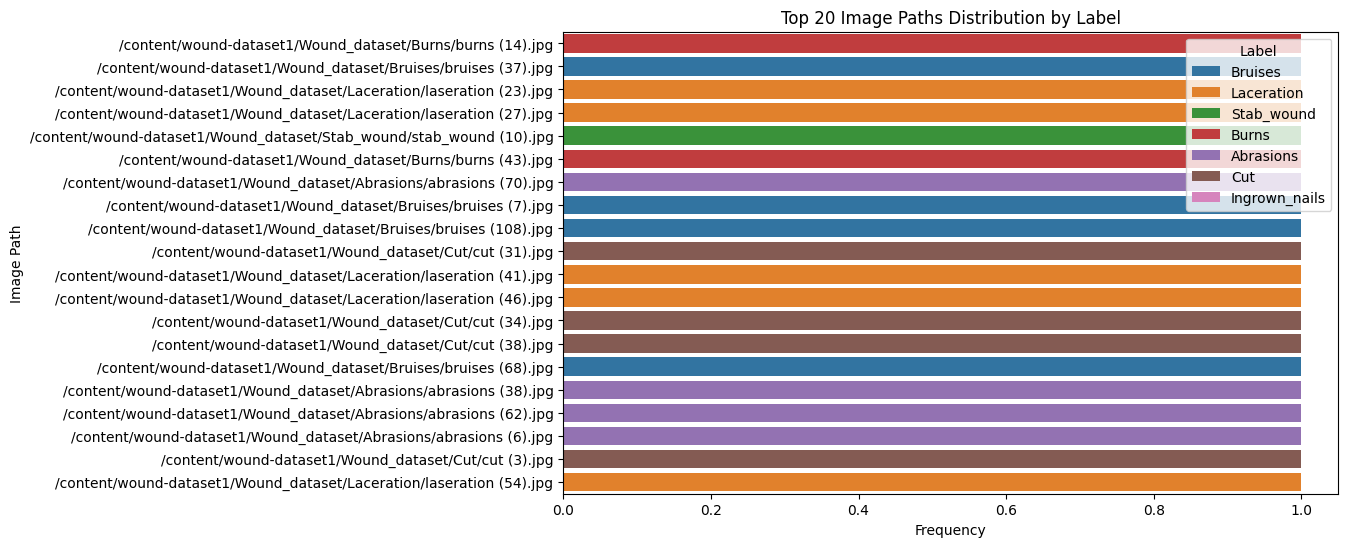

Column Image_Path has 400 unique values.
Column Label has 7 unique values.


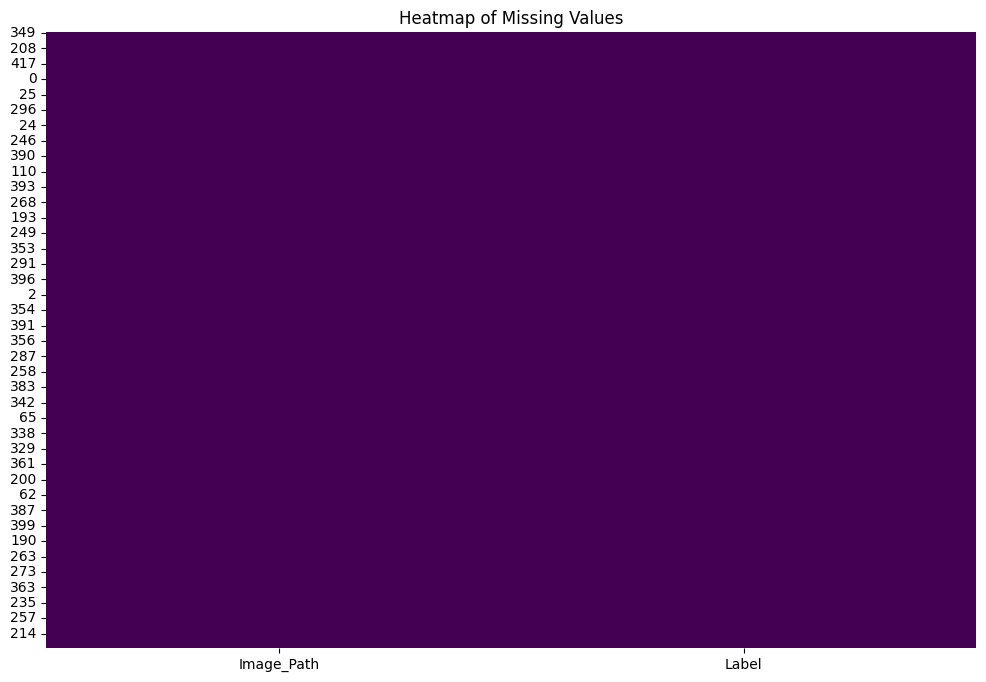

Label
Bruises          116
Abrasions         74
Laceration        56
Burns             55
Cut               49
Ingrown_nails     28
Stab_wound        22
Name: count, dtype: int64


In [ ]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [ ]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Label         0
dtype: int64
0


# Customizing model according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [10]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D

from keras.layers import Dropout

def create_model(base_model, input_shape, num_classes):
    base_model.trainable = True  # Unfreeze the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [11]:
def model_training (base_models):
  # Directory to save the models
  save_dir = 'saved_models'
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  # Adjustments for ResNet50
  # Train and evaluate each model
  histories = {}
  for base_model, input_shape, model_name in base_models:
      # Resize data if necessary (dummy data, so not applicable here)
      if input_shape != (224, 224, 3):
          # Resize X_train and X_val to the required input_shape
          # This is just a placeholder, implement actual resizing if needed
          pass

      # Create the model
      model = create_model(base_model, input_shape, num_classes)

      if model_name == 'ResNet50':
          # Unfreeze more layers for ResNet50 and adjust learning rate
          for layer in model.layers[-30:]:
              layer.trainable = True
          epochs = 50
          optimizer = optimizers.Adam(learning_rate=0.0001)
      else:
          epochs = 50
          optimizer = optimizers.Adam()

      # Compile the model
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

      print(f'Training {model_name}...')
      history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=epochs)
      histories[model_name] = history

      # Saving the model after training
      model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
      print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

In [12]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def train_and_evaluate(model, train_data, val_data, model_name, epochs=15):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    checkpoint = ModelCheckpoint(f'saved_models/{model_name}_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the specified number of epochs
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(train_data),
                        epochs=epochs,
                        #callbacks=[early_stopping]
                        )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Get the true labels and predictions
    val_data.reset()  # Reset the generator
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(30, 30))  # Increase the size of the plot significantly
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

9406464/9406464 [==============================] - 0s 0us/step
Training MobileNetV2...
Epoch 1/50
13/13 [==============================] - 41s 681ms/step - loss: 2.1608 - accuracy: 0.1900 - val_loss: 1.7158 - val_accuracy: 0.3182
Epoch 2/50
13/13 [==============================] - 8s 646ms/step - loss: 1.8585 - accuracy: 0.3050 - val_loss: 1.8429 - val_accuracy: 0.3182
Epoch 3/50
13/13 [==============================] - 5s 410ms/step - loss: 1.7609 - accuracy: 0.3300 - val_loss: 1.9438 - val_accuracy: 0.3182
Epoch 4/50
13/13 [==============================] - 6s 449ms/step - loss: 1.5177 - accuracy: 0.4275 - val_loss: 2.1789 - val_accuracy: 0.3182
Epoch 5/50
13/13 [==============================] - 5s 410ms/step - loss: 1.4752 - accuracy: 0.4275 - val_loss: 2.1591 - val_accuracy: 0.3182
Epoch 6/50
13/13 [==============================] - 6s 413ms/step - loss: 1.2793 - accuracy: 0.5200 - val_loss: 2.2525 - val_accuracy: 0.3182
Epoch 7/50
13/13 [==============================] - 7s 508ms

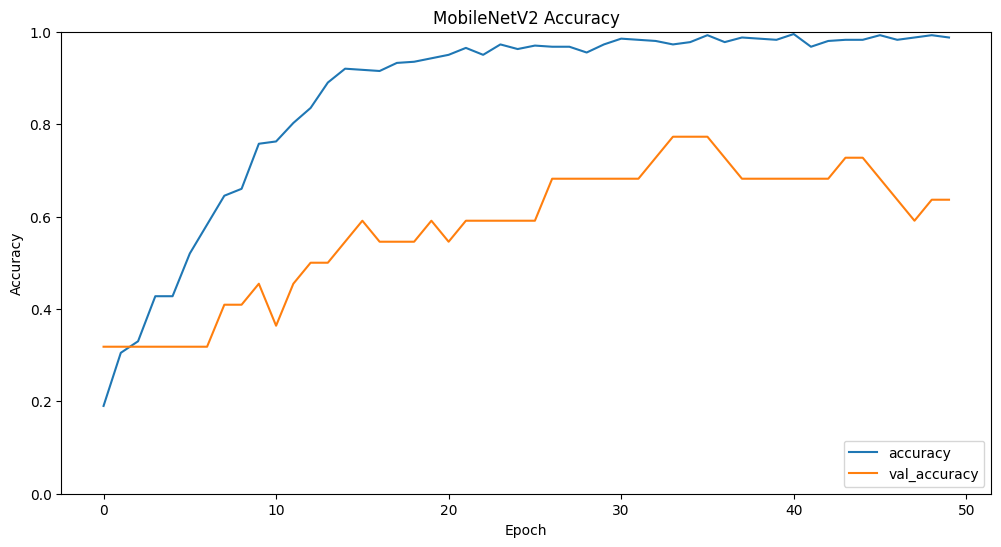

1/1 [==============================] - 1s 807ms/step


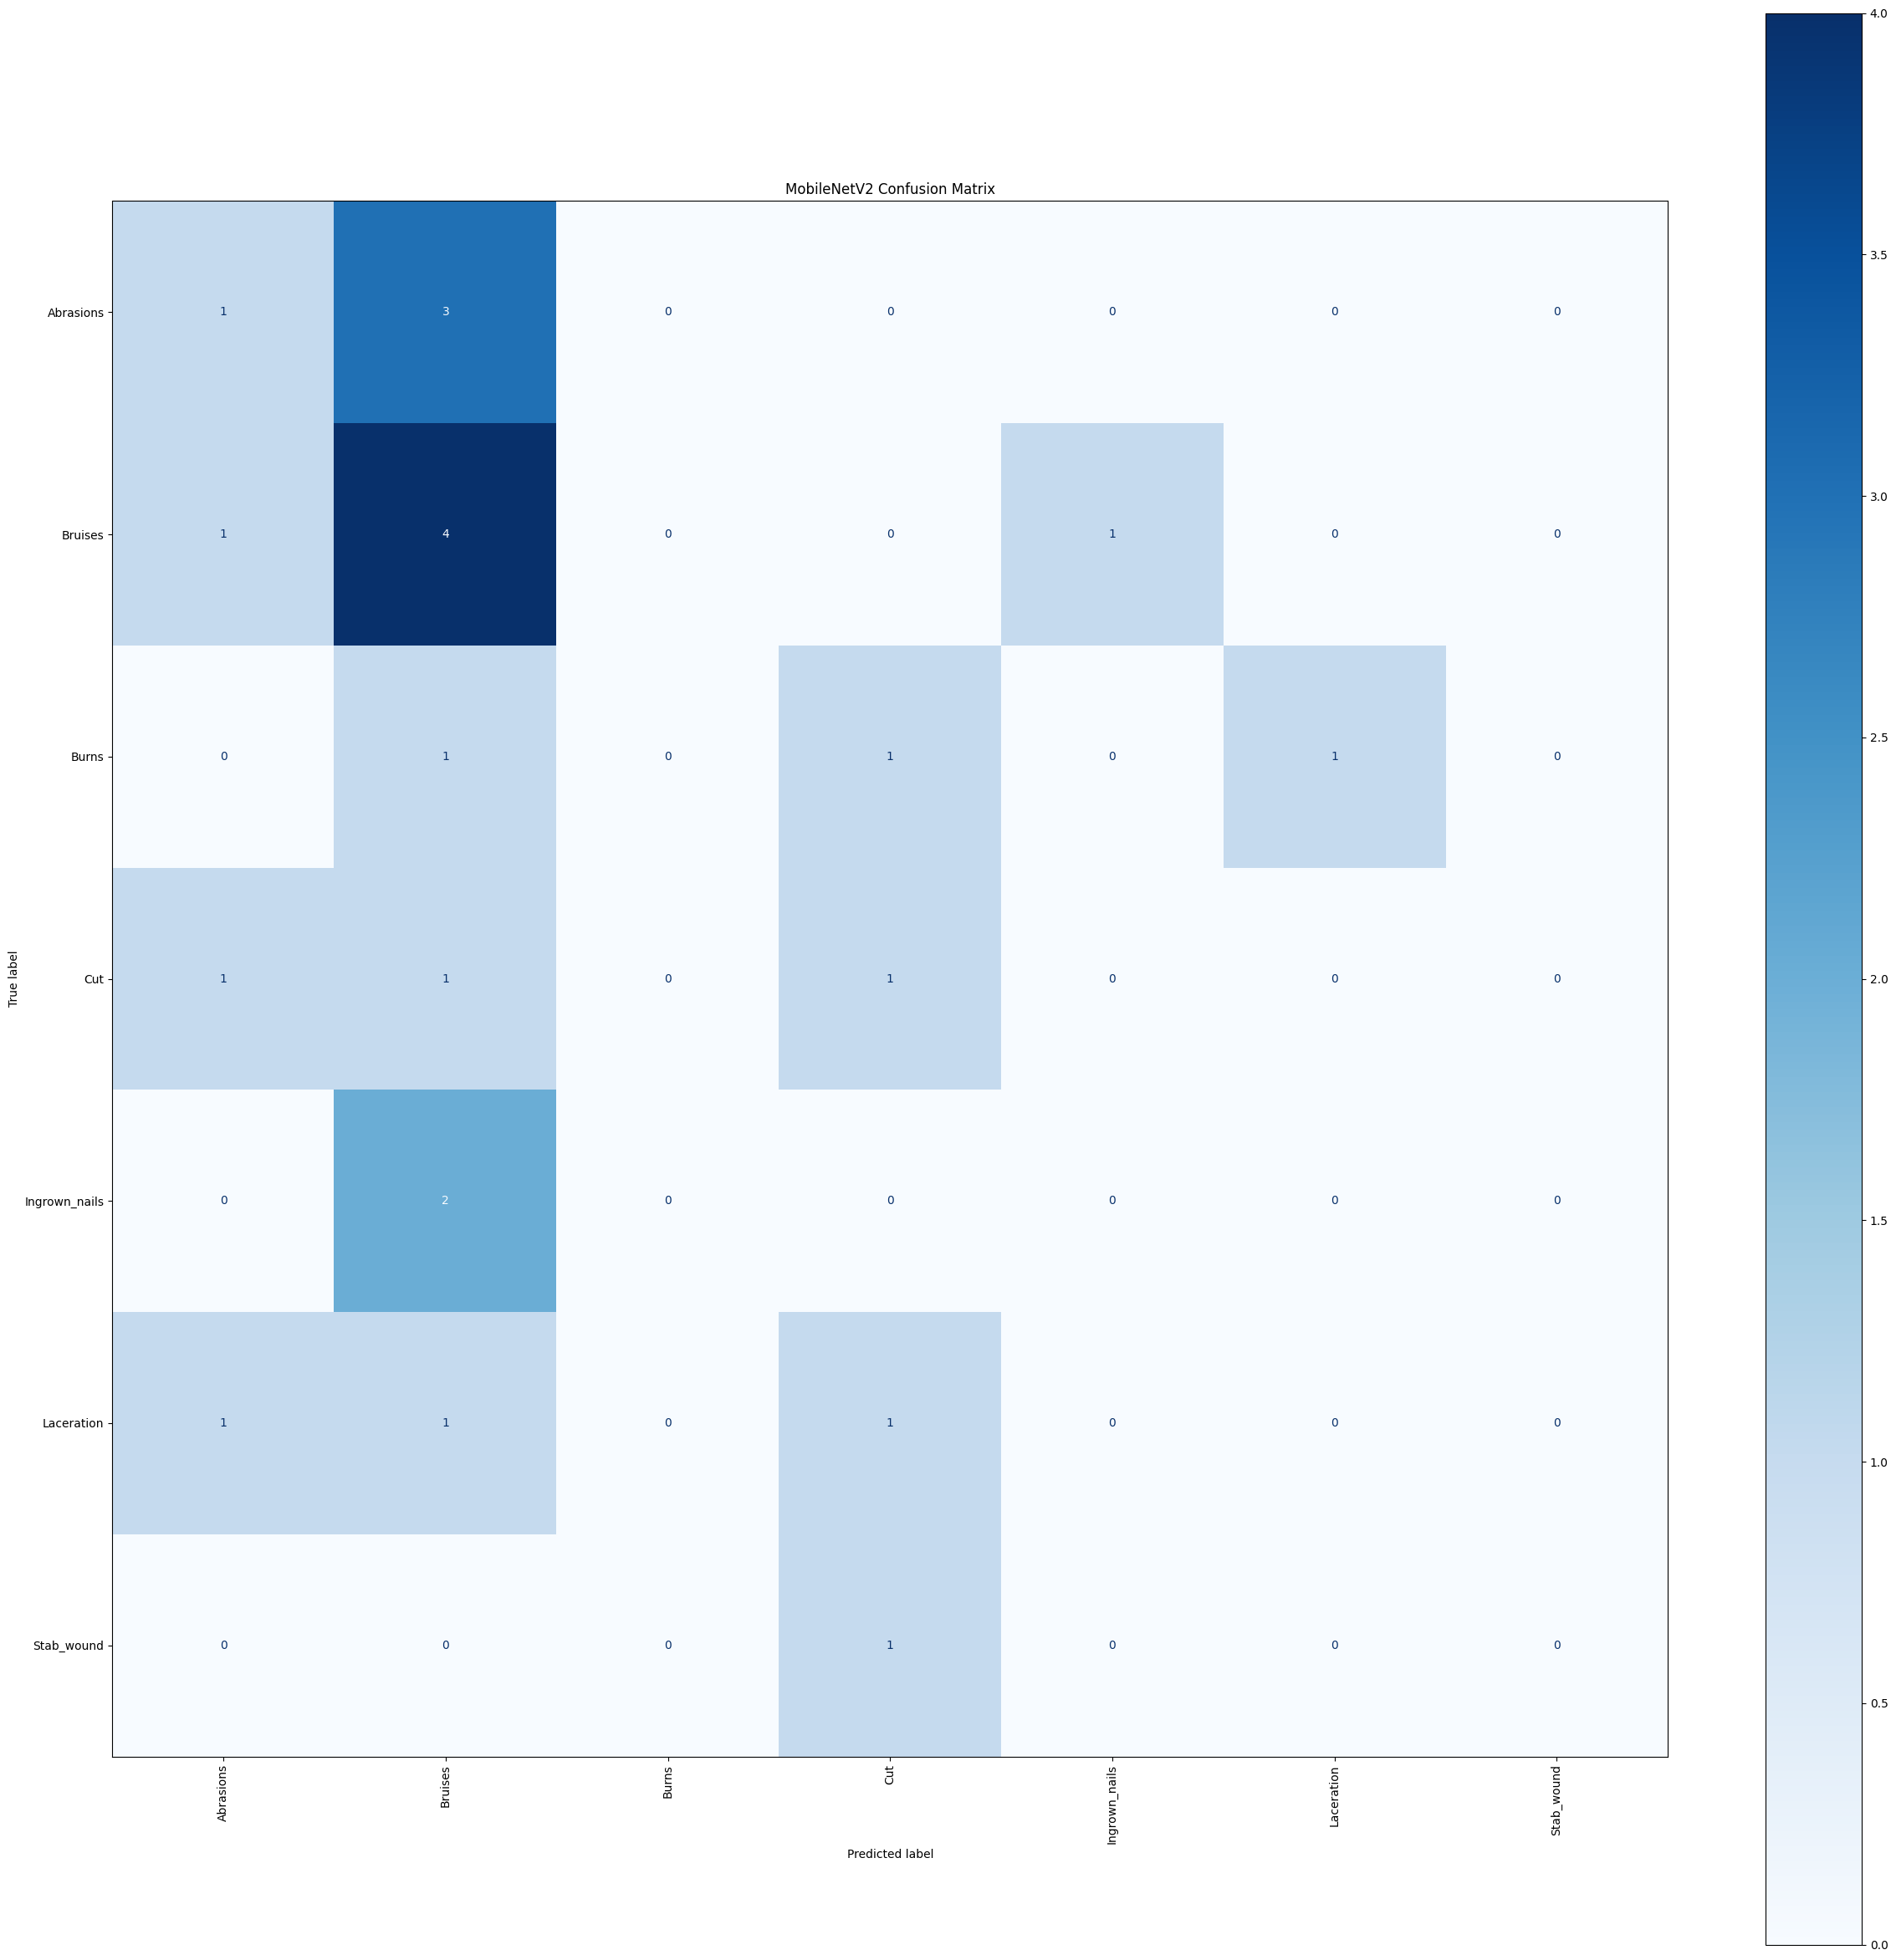

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved MobileNetV2 model to saved_models/MobileNetV2_saved.h5


In [13]:
# List of base models with their respective input shapes
base_models1 = [
    (MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'MobileNetV2'),
]
model_training(base_models1)

87910968/87910968 [==============================] - 1s 0us/step
Training InceptionV3...
Epoch 1/50
13/13 [==============================] - 65s 1s/step - loss: 2.1515 - accuracy: 0.2100 - val_loss: 1.8267 - val_accuracy: 0.2727
Epoch 2/50
13/13 [==============================] - 6s 449ms/step - loss: 1.7853 - accuracy: 0.2850 - val_loss: 1.6892 - val_accuracy: 0.3636
Epoch 3/50
13/13 [==============================] - 6s 449ms/step - loss: 1.6393 - accuracy: 0.3750 - val_loss: 1.4129 - val_accuracy: 0.5000
Epoch 4/50
13/13 [==============================] - 9s 675ms/step - loss: 1.4818 - accuracy: 0.4675 - val_loss: 1.2181 - val_accuracy: 0.6364
Epoch 5/50
13/13 [==============================] - 6s 459ms/step - loss: 1.2876 - accuracy: 0.5450 - val_loss: 0.9154 - val_accuracy: 0.6818
Epoch 6/50
13/13 [==============================] - 7s 537ms/step - loss: 1.0415 - accuracy: 0.6225 - val_loss: 0.8182 - val_accuracy: 0.7727
Epoch 7/50
13/13 [==============================] - 6s 455ms/

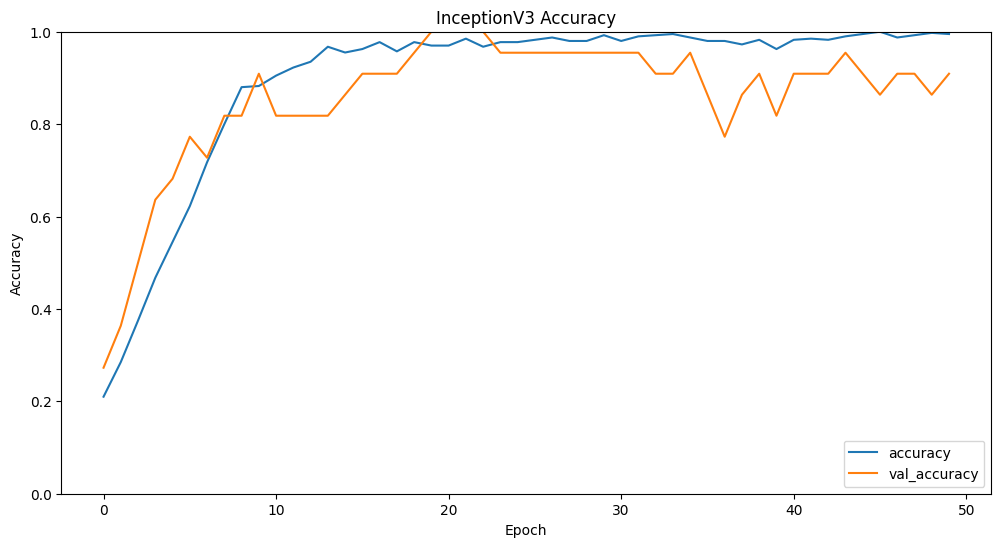

1/1 [==============================] - 1s 1s/step


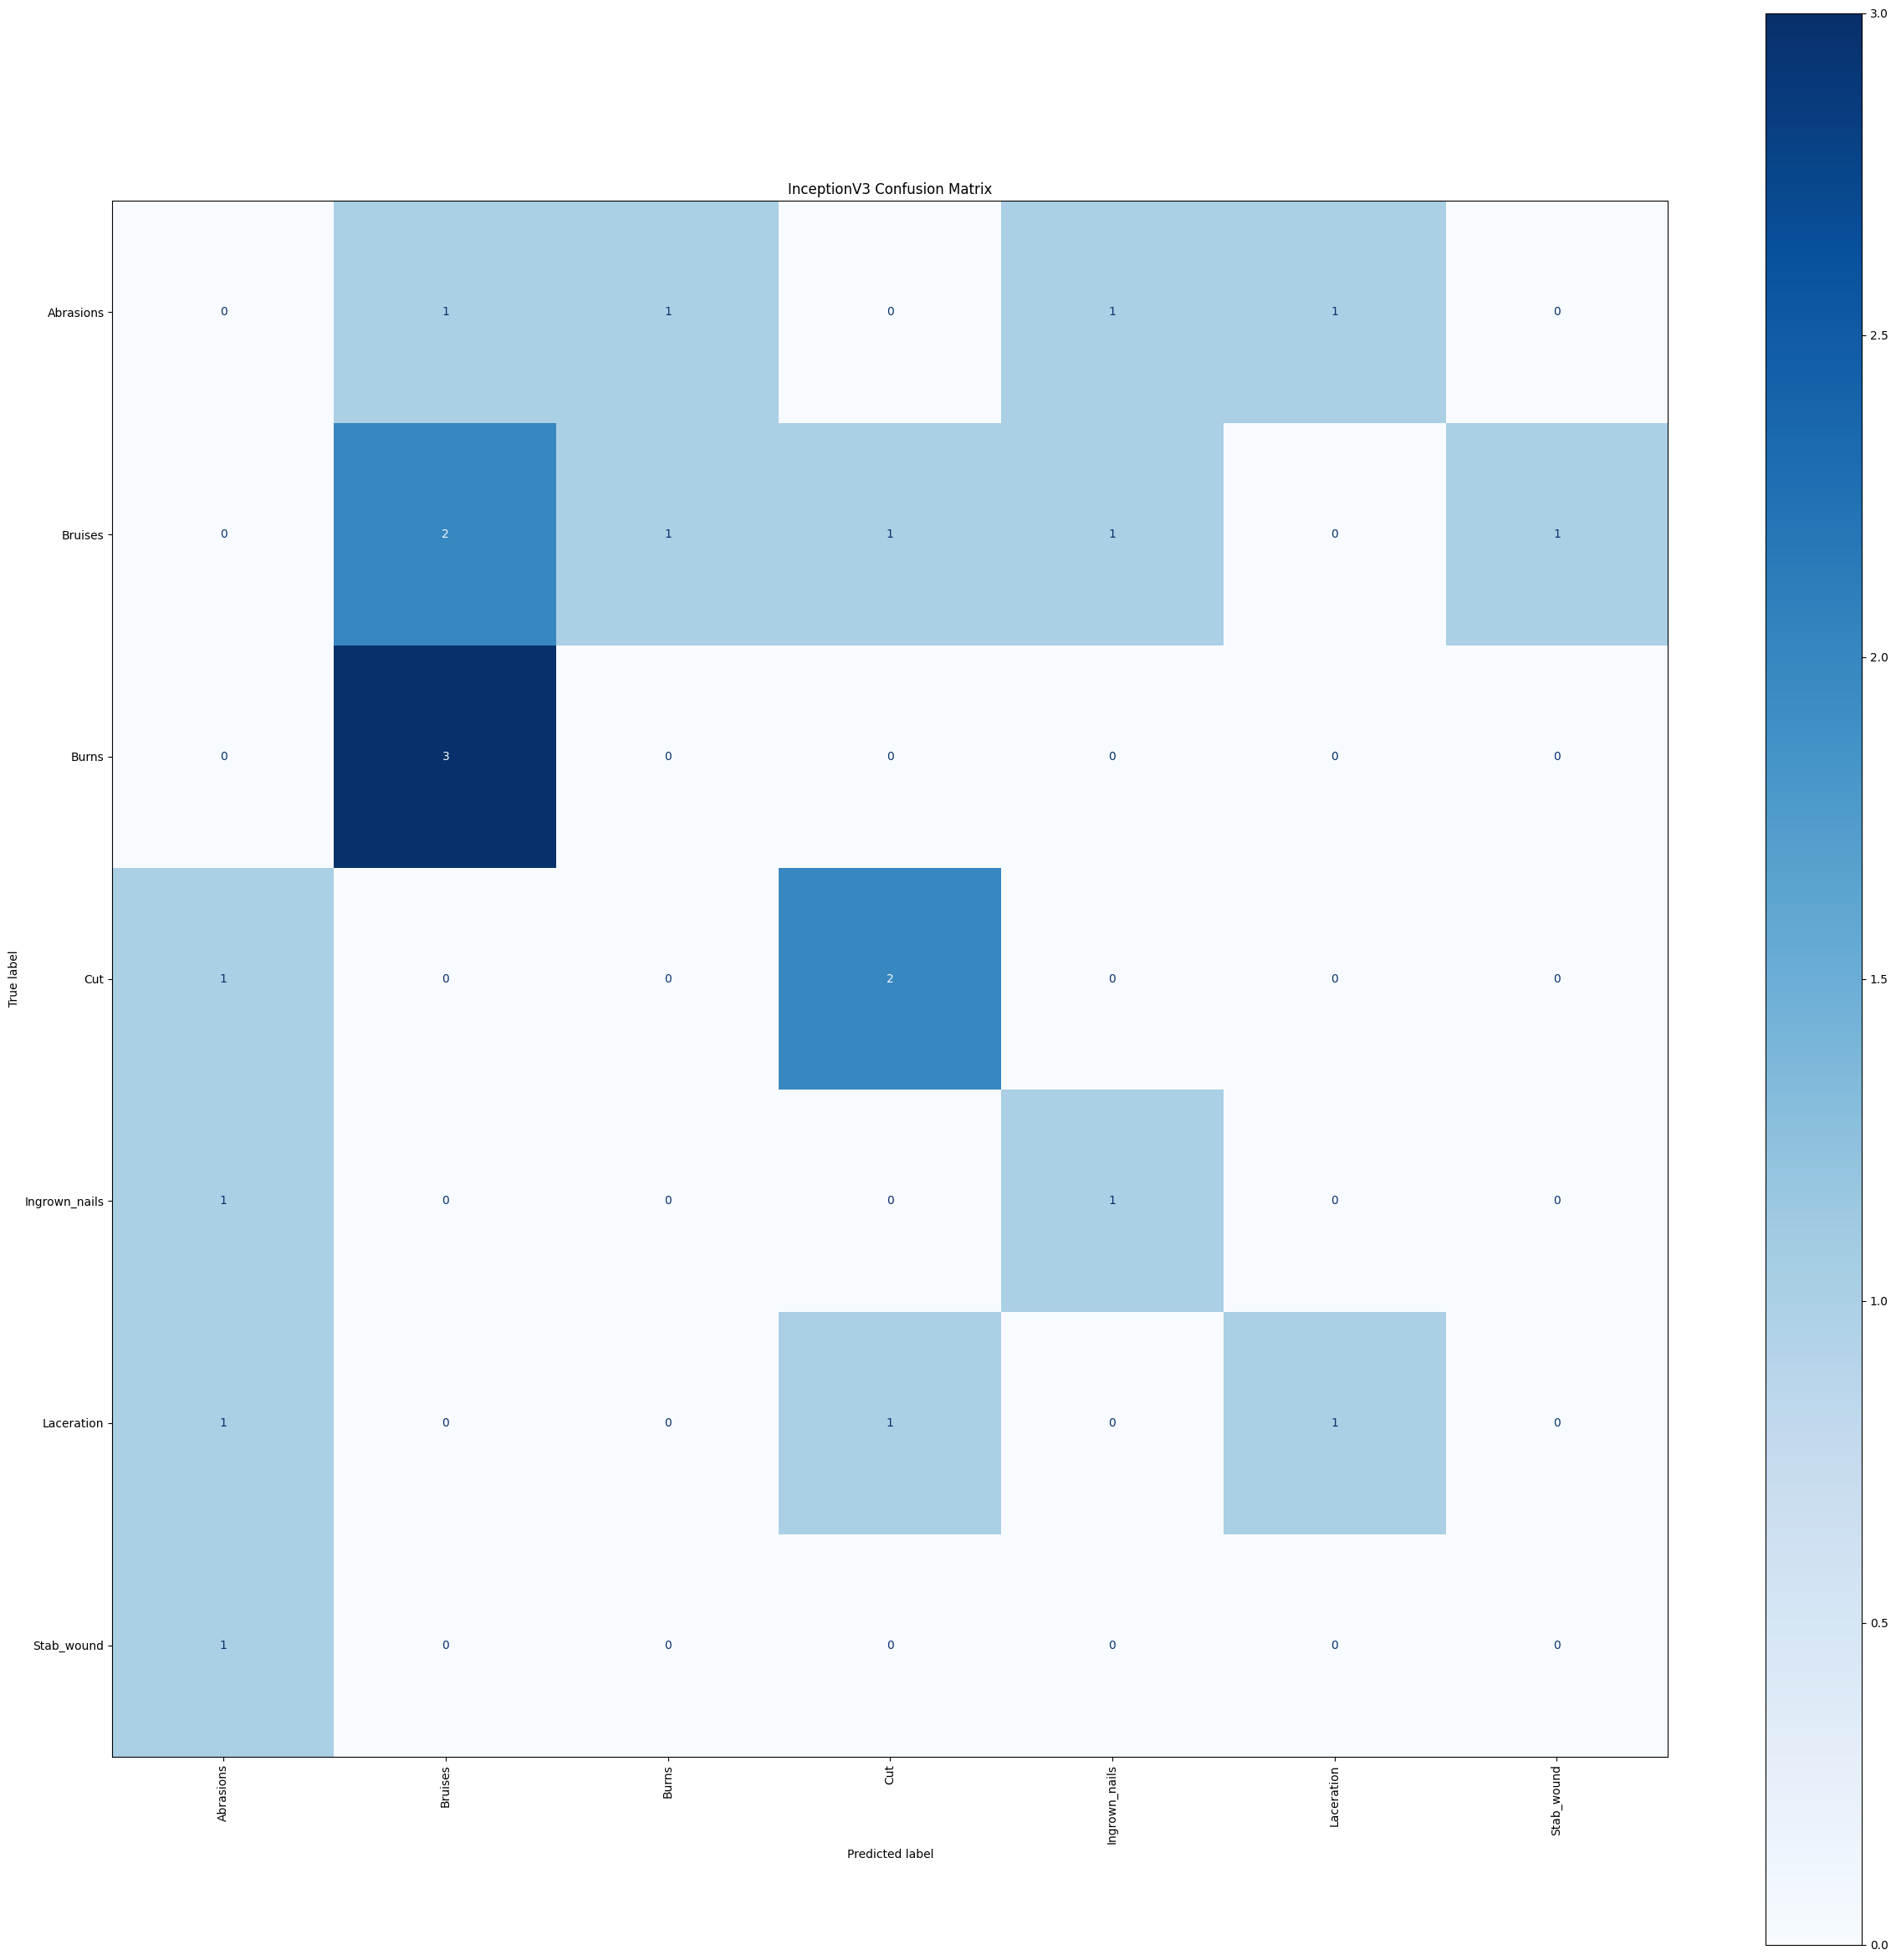

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


In [14]:
base_models2 = [
  (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'InceptionV3')
]
model_training (base_models2)

83683744/83683744 [==============================] - 0s 0us/step
Training Xception...
Epoch 1/50
13/13 [==============================] - 47s 1s/step - loss: 1.8749 - accuracy: 0.2600 - val_loss: 1.7249 - val_accuracy: 0.3182
Epoch 2/50
13/13 [==============================] - 8s 613ms/step - loss: 1.7142 - accuracy: 0.3225 - val_loss: 1.6841 - val_accuracy: 0.3182
Epoch 3/50
13/13 [==============================] - 8s 605ms/step - loss: 1.5802 - accuracy: 0.3400 - val_loss: 1.7671 - val_accuracy: 0.3182
Epoch 4/50
13/13 [==============================] - 8s 634ms/step - loss: 1.4615 - accuracy: 0.4075 - val_loss: 1.5460 - val_accuracy: 0.3636
Epoch 5/50
13/13 [==============================] - 7s 553ms/step - loss: 1.3075 - accuracy: 0.5225 - val_loss: 1.5681 - val_accuracy: 0.3636
Epoch 6/50
13/13 [==============================] - 9s 623ms/step - loss: 1.1605 - accuracy: 0.5675 - val_loss: 1.2791 - val_accuracy: 0.5455
Epoch 7/50
13/13 [==============================] - 8s 624ms/ste

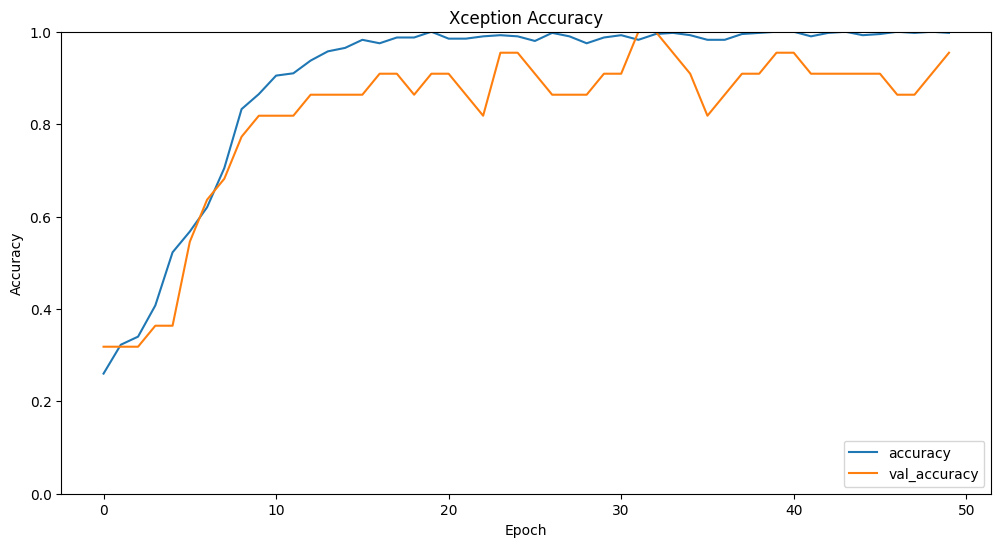

1/1 [==============================] - 1s 769ms/step


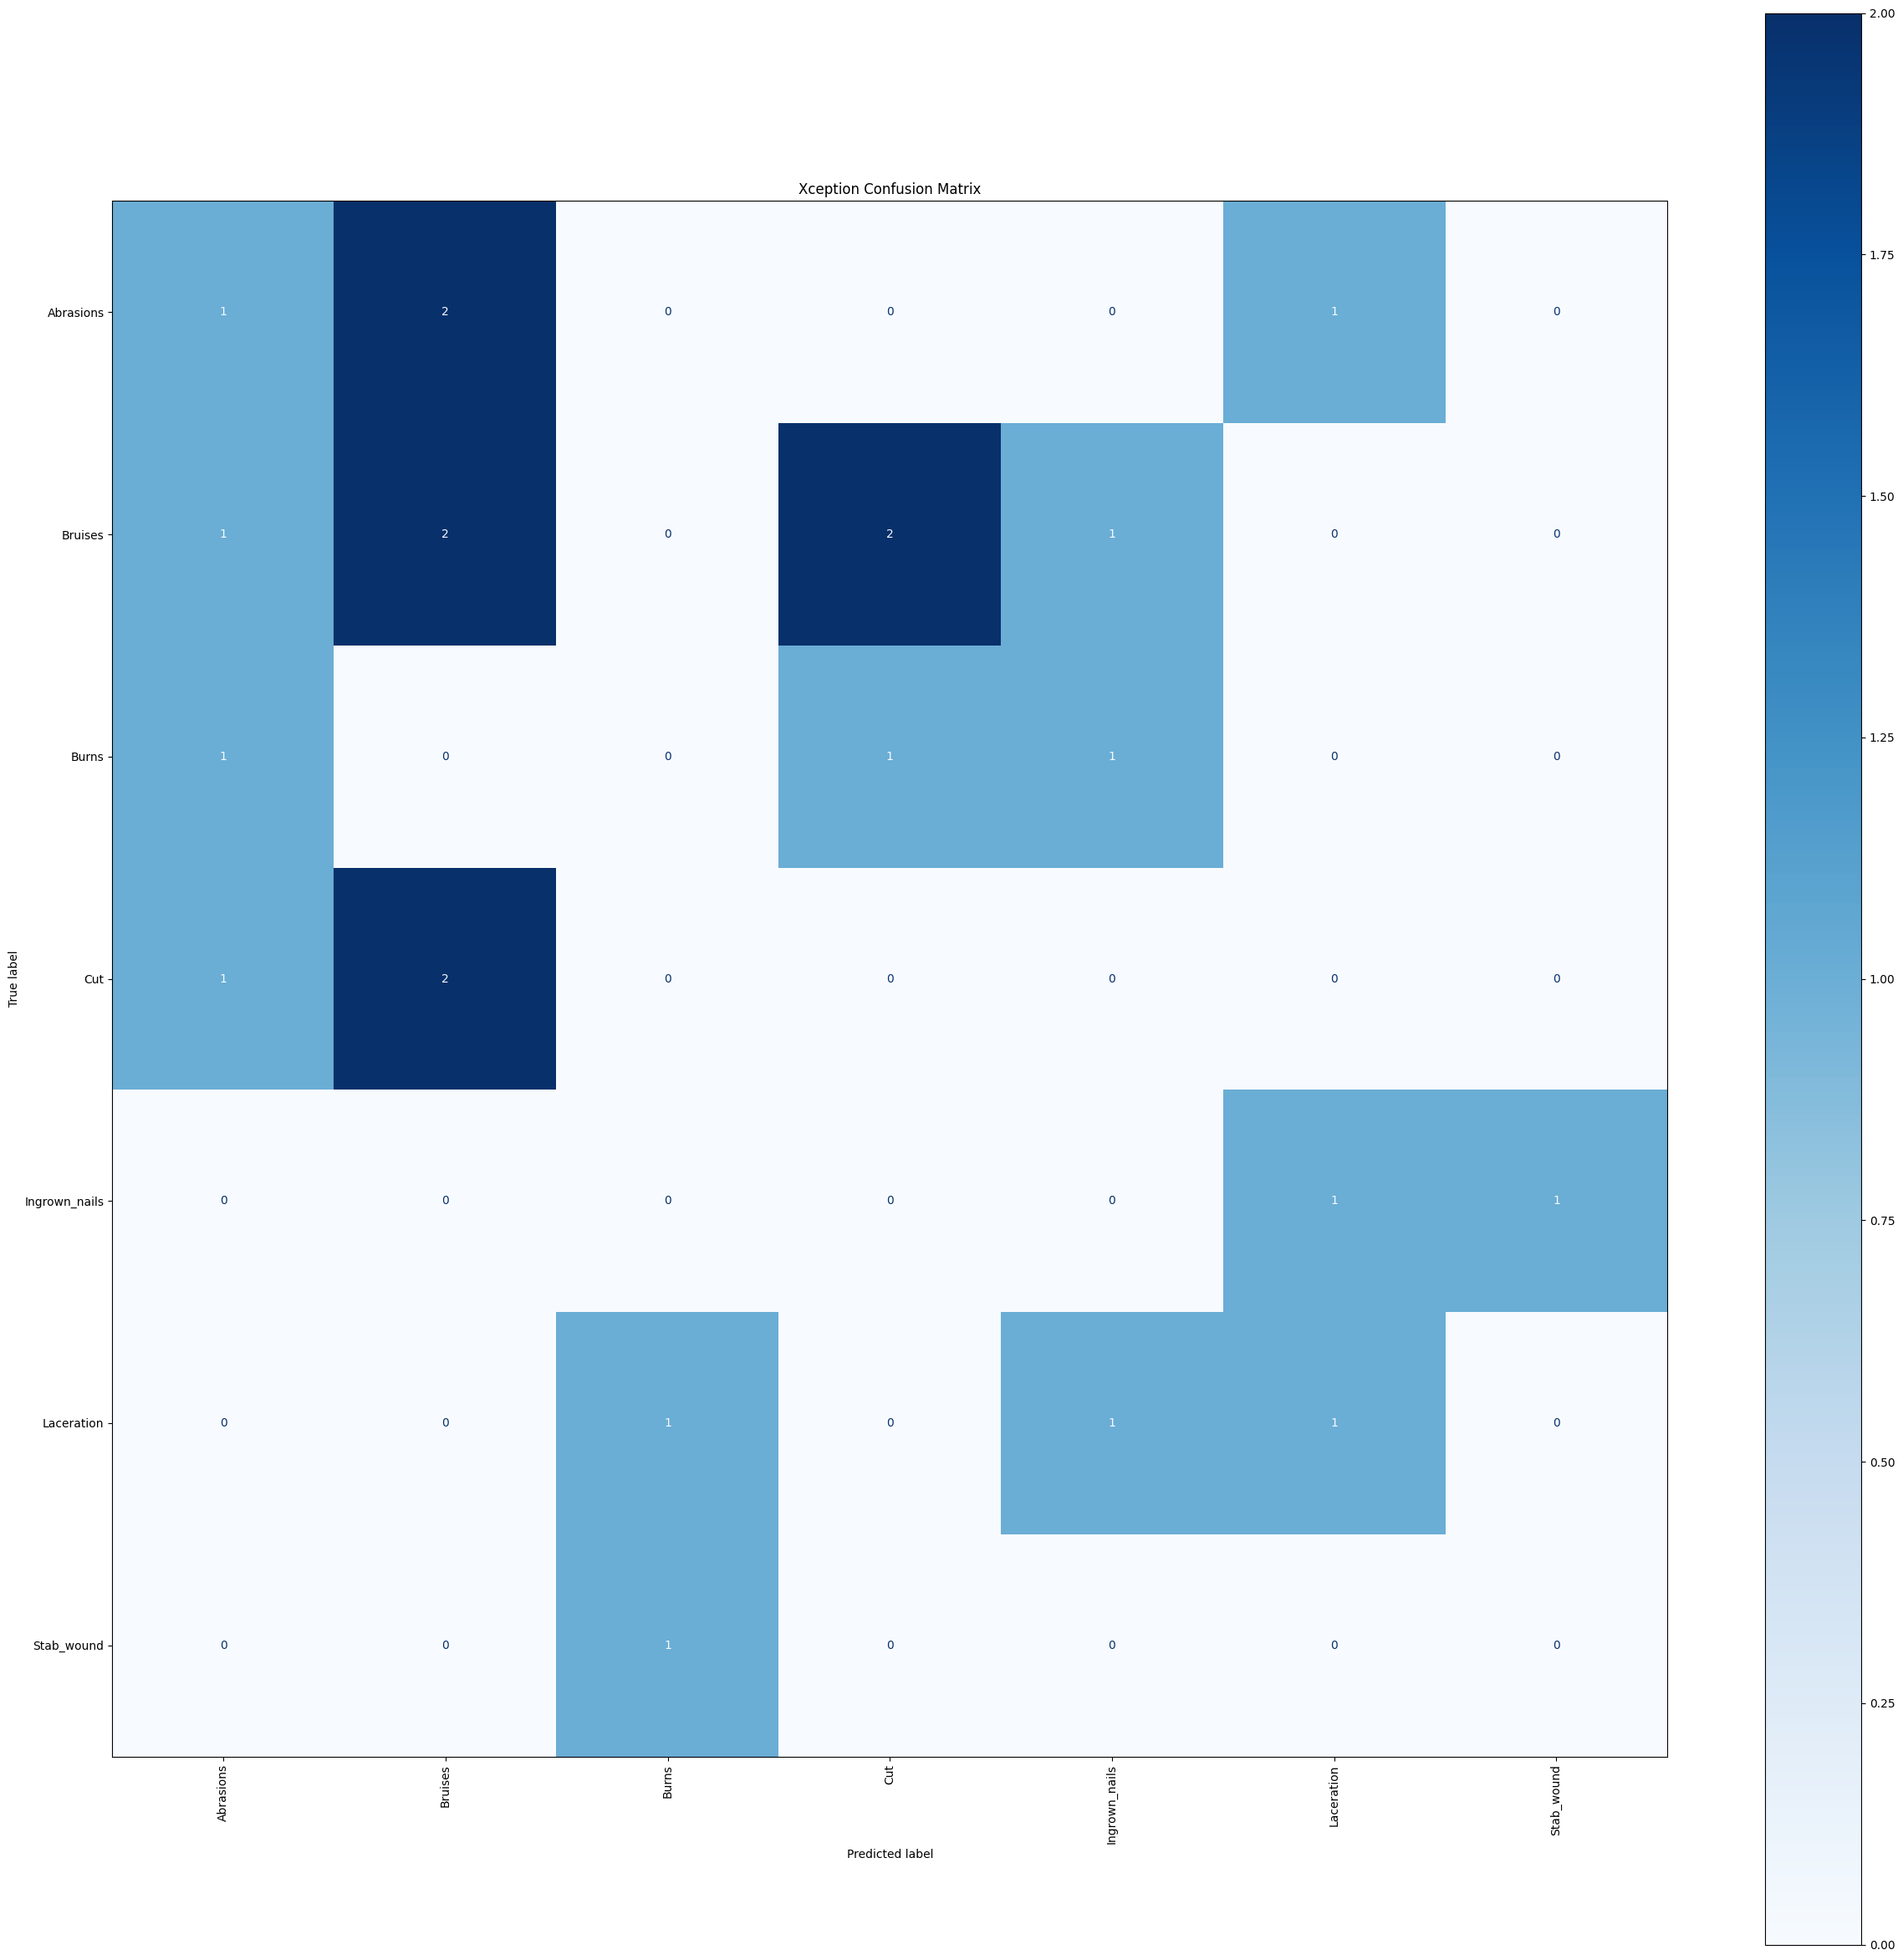

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved Xception model to saved_models/Xception_saved.h5


In [15]:
base_models3 = [
  (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]
model_training (base_models3)

94668760/94668760 [==============================] - 1s 0us/step
Training ResNet50V2...
Epoch 1/50
13/13 [==============================] - 47s 1s/step - loss: 2.1172 - accuracy: 0.1875 - val_loss: 1.5604 - val_accuracy: 0.3636
Epoch 2/50
13/13 [==============================] - 7s 568ms/step - loss: 1.7601 - accuracy: 0.3550 - val_loss: 1.4503 - val_accuracy: 0.5455
Epoch 3/50
13/13 [==============================] - 6s 470ms/step - loss: 1.5271 - accuracy: 0.4250 - val_loss: 1.2282 - val_accuracy: 0.5909
Epoch 4/50
13/13 [==============================] - 7s 560ms/step - loss: 1.3700 - accuracy: 0.5075 - val_loss: 0.9823 - val_accuracy: 0.6364
Epoch 5/50
13/13 [==============================] - 6s 476ms/step - loss: 1.1990 - accuracy: 0.5525 - val_loss: 0.8811 - val_accuracy: 0.6364
Epoch 6/50
13/13 [==============================] - 6s 478ms/step - loss: 1.0350 - accuracy: 0.6250 - val_loss: 0.7551 - val_accuracy: 0.6818
Epoch 7/50
13/13 [==============================] - 7s 570ms/s

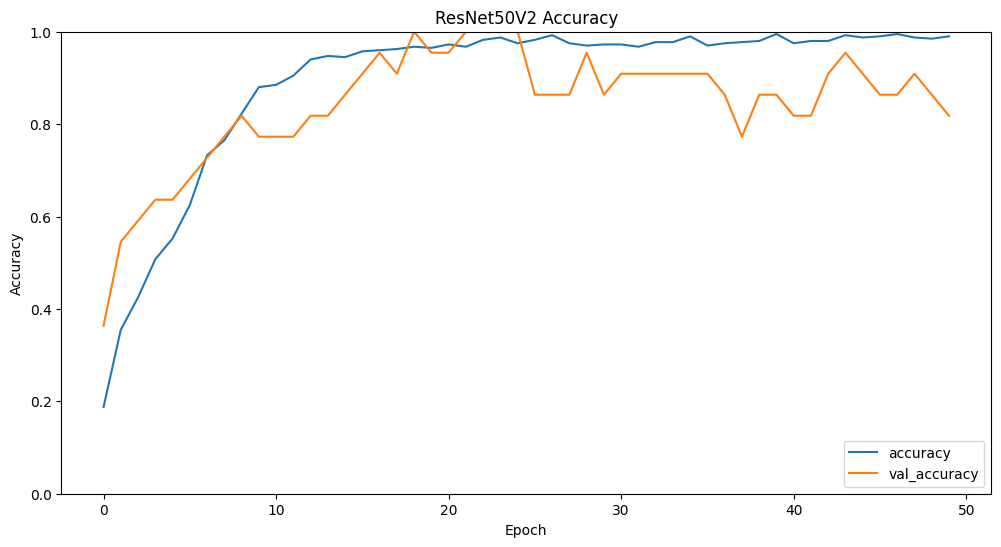

1/1 [==============================] - 1s 839ms/step


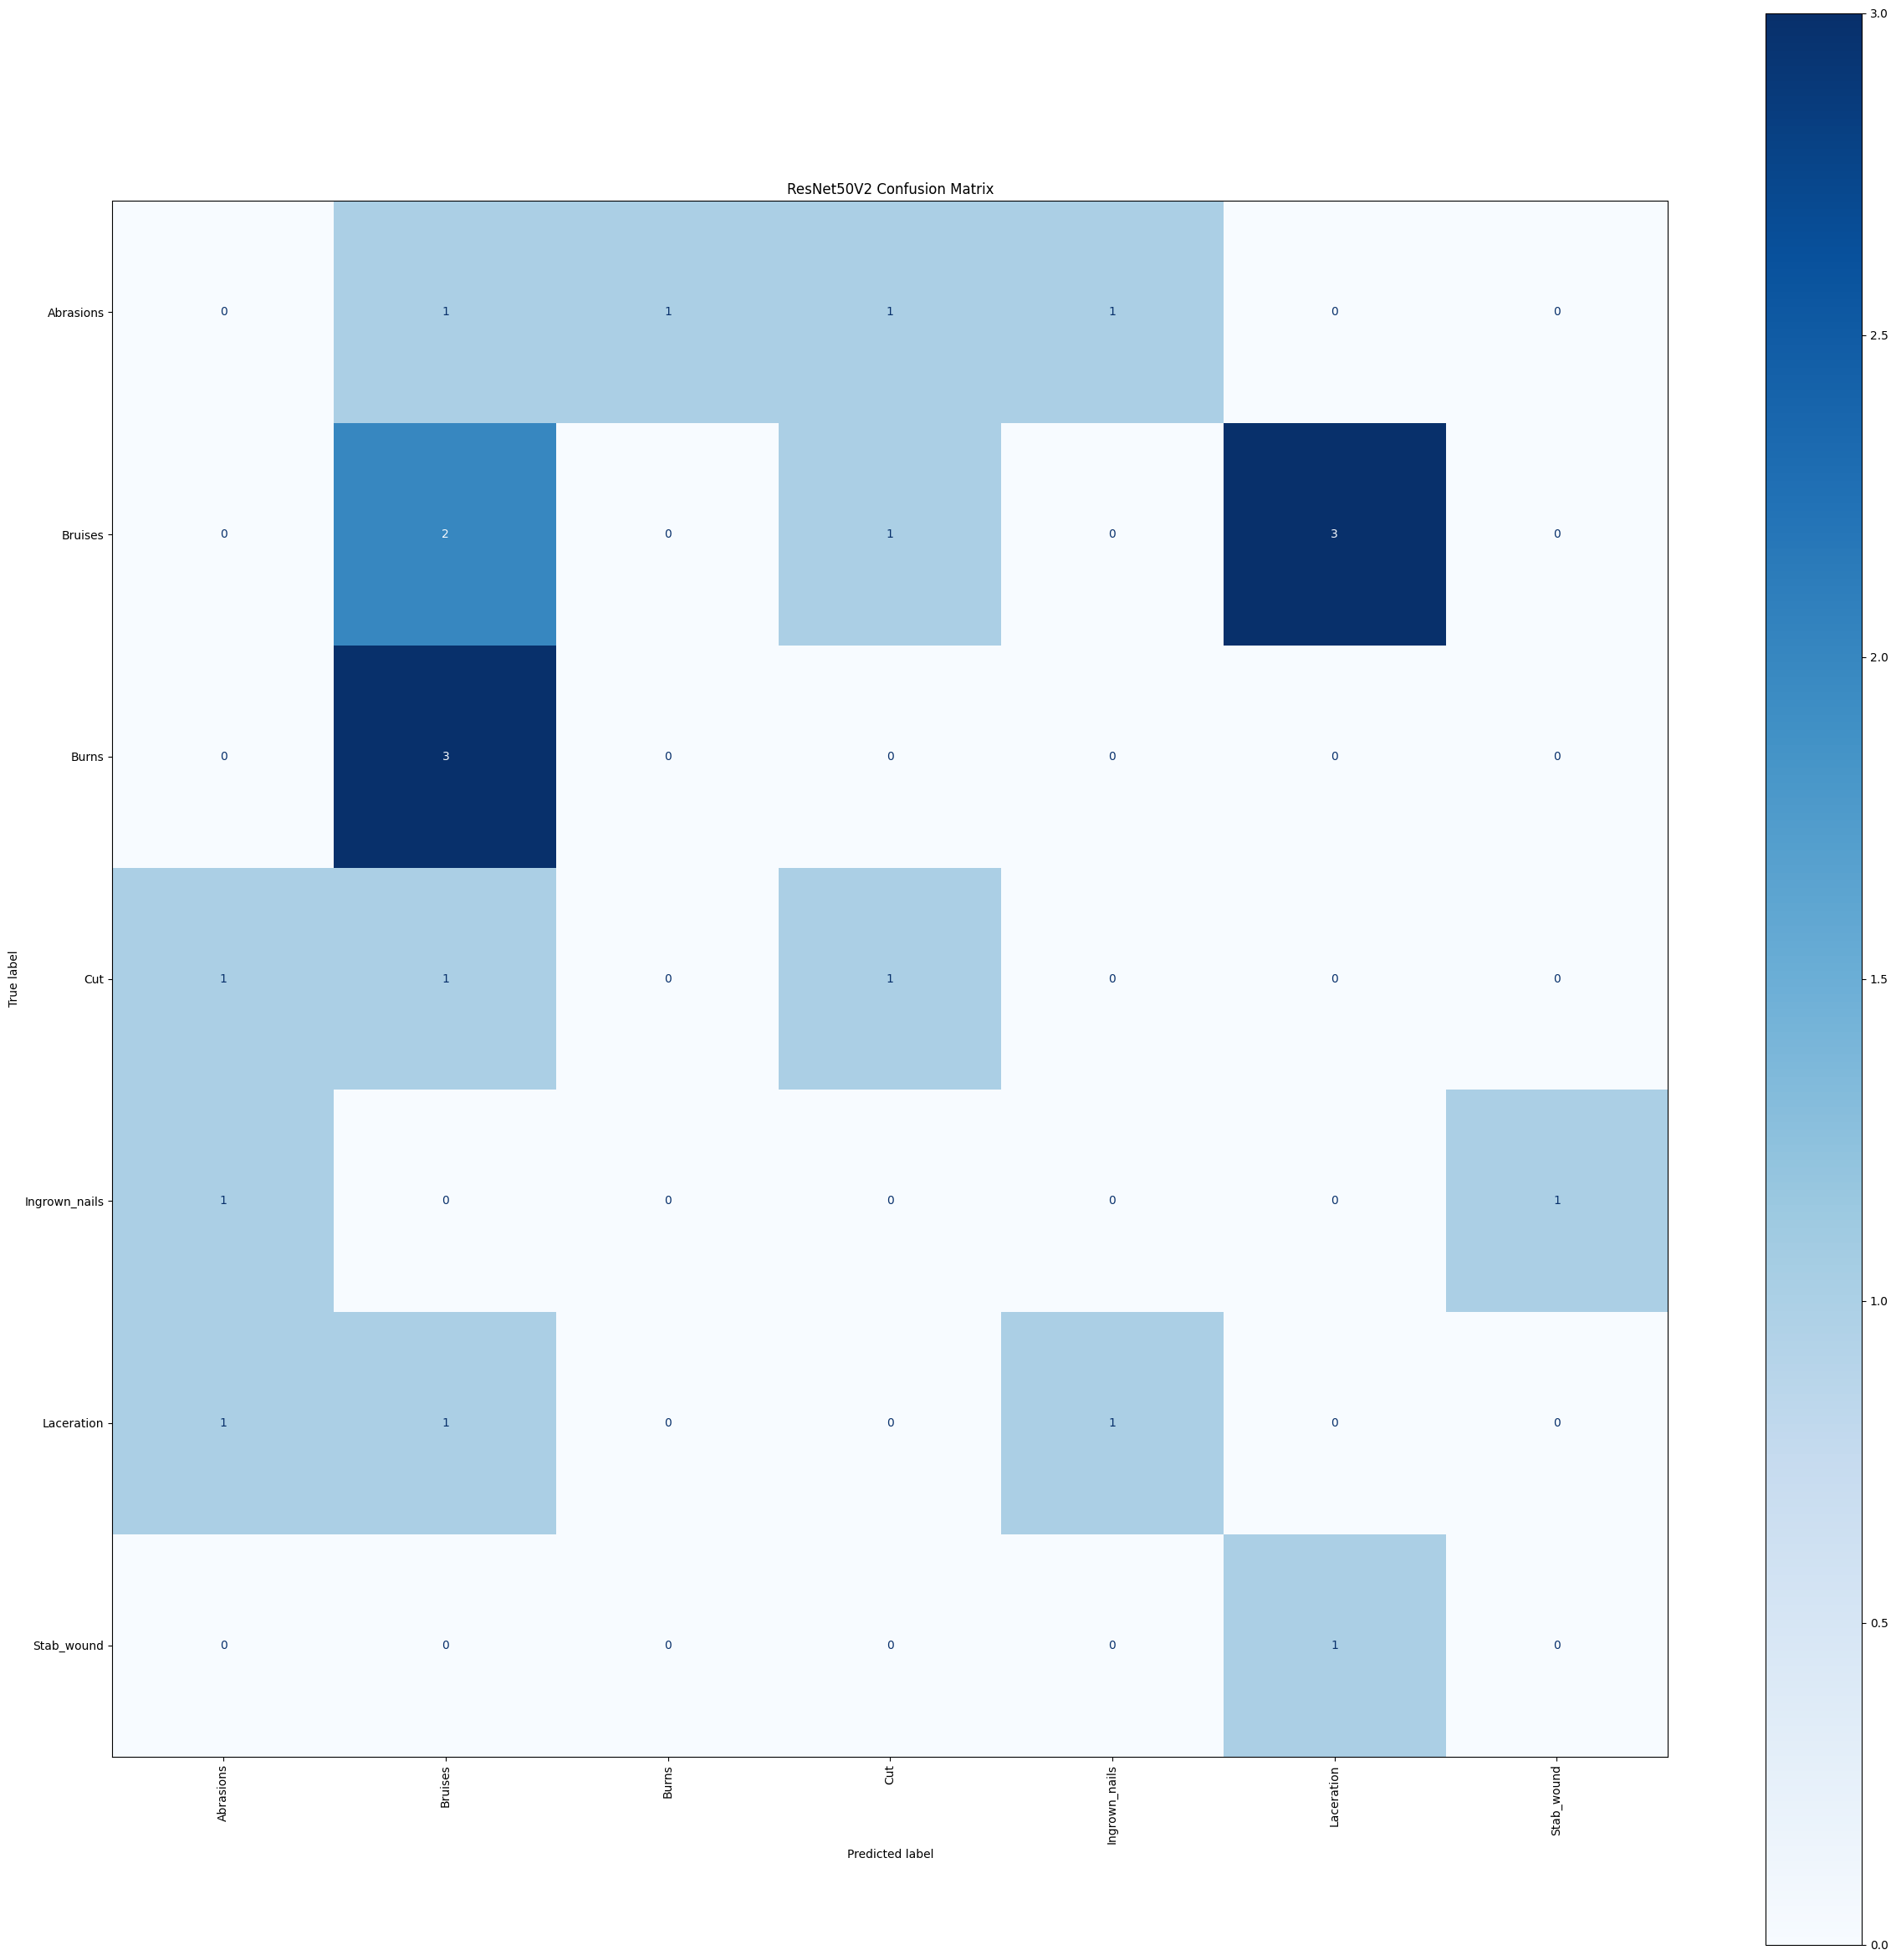

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


In [16]:
base_models4 = [
  (ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50V2')
]
model_training (base_models4)

29084464/29084464 [==============================] - 0s 0us/step
Training DenseNet121...
Epoch 1/50
13/13 [==============================] - 87s 2s/step - loss: 2.5162 - accuracy: 0.1950 - val_loss: 1.8050 - val_accuracy: 0.2273
Epoch 2/50
13/13 [==============================] - 8s 570ms/step - loss: 2.0592 - accuracy: 0.2675 - val_loss: 1.6947 - val_accuracy: 0.3182
Epoch 3/50
13/13 [==============================] - 7s 491ms/step - loss: 1.7754 - accuracy: 0.3325 - val_loss: 1.5624 - val_accuracy: 0.4545
Epoch 4/50
13/13 [==============================] - 7s 501ms/step - loss: 1.5982 - accuracy: 0.3900 - val_loss: 1.4477 - val_accuracy: 0.5000
Epoch 5/50
13/13 [==============================] - 8s 597ms/step - loss: 1.3579 - accuracy: 0.4925 - val_loss: 1.3239 - val_accuracy: 0.5455
Epoch 6/50
13/13 [==============================] - 7s 501ms/step - loss: 1.2574 - accuracy: 0.5400 - val_loss: 1.2974 - val_accuracy: 0.5455
Epoch 7/50
13/13 [==============================] - 7s 488ms/

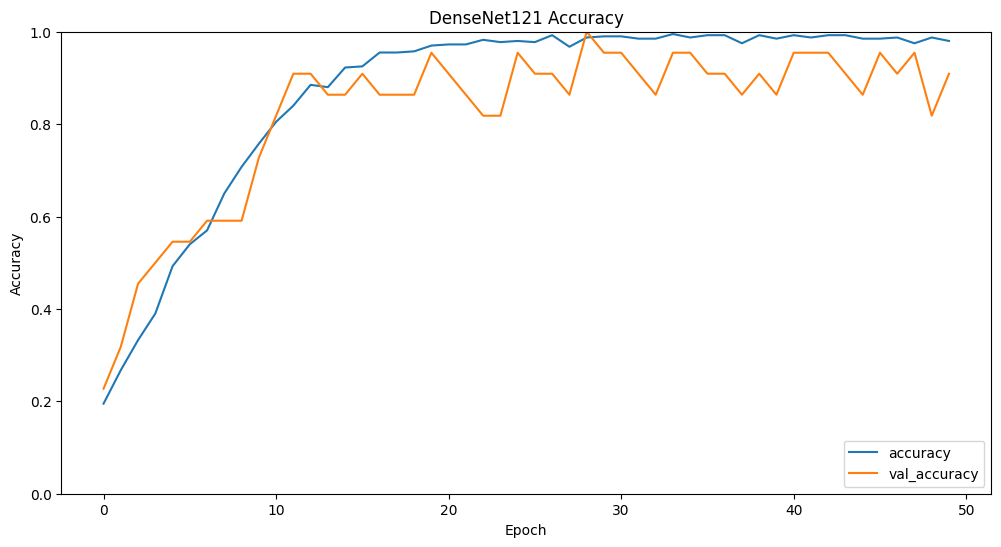

1/1 [==============================] - 2s 2s/step


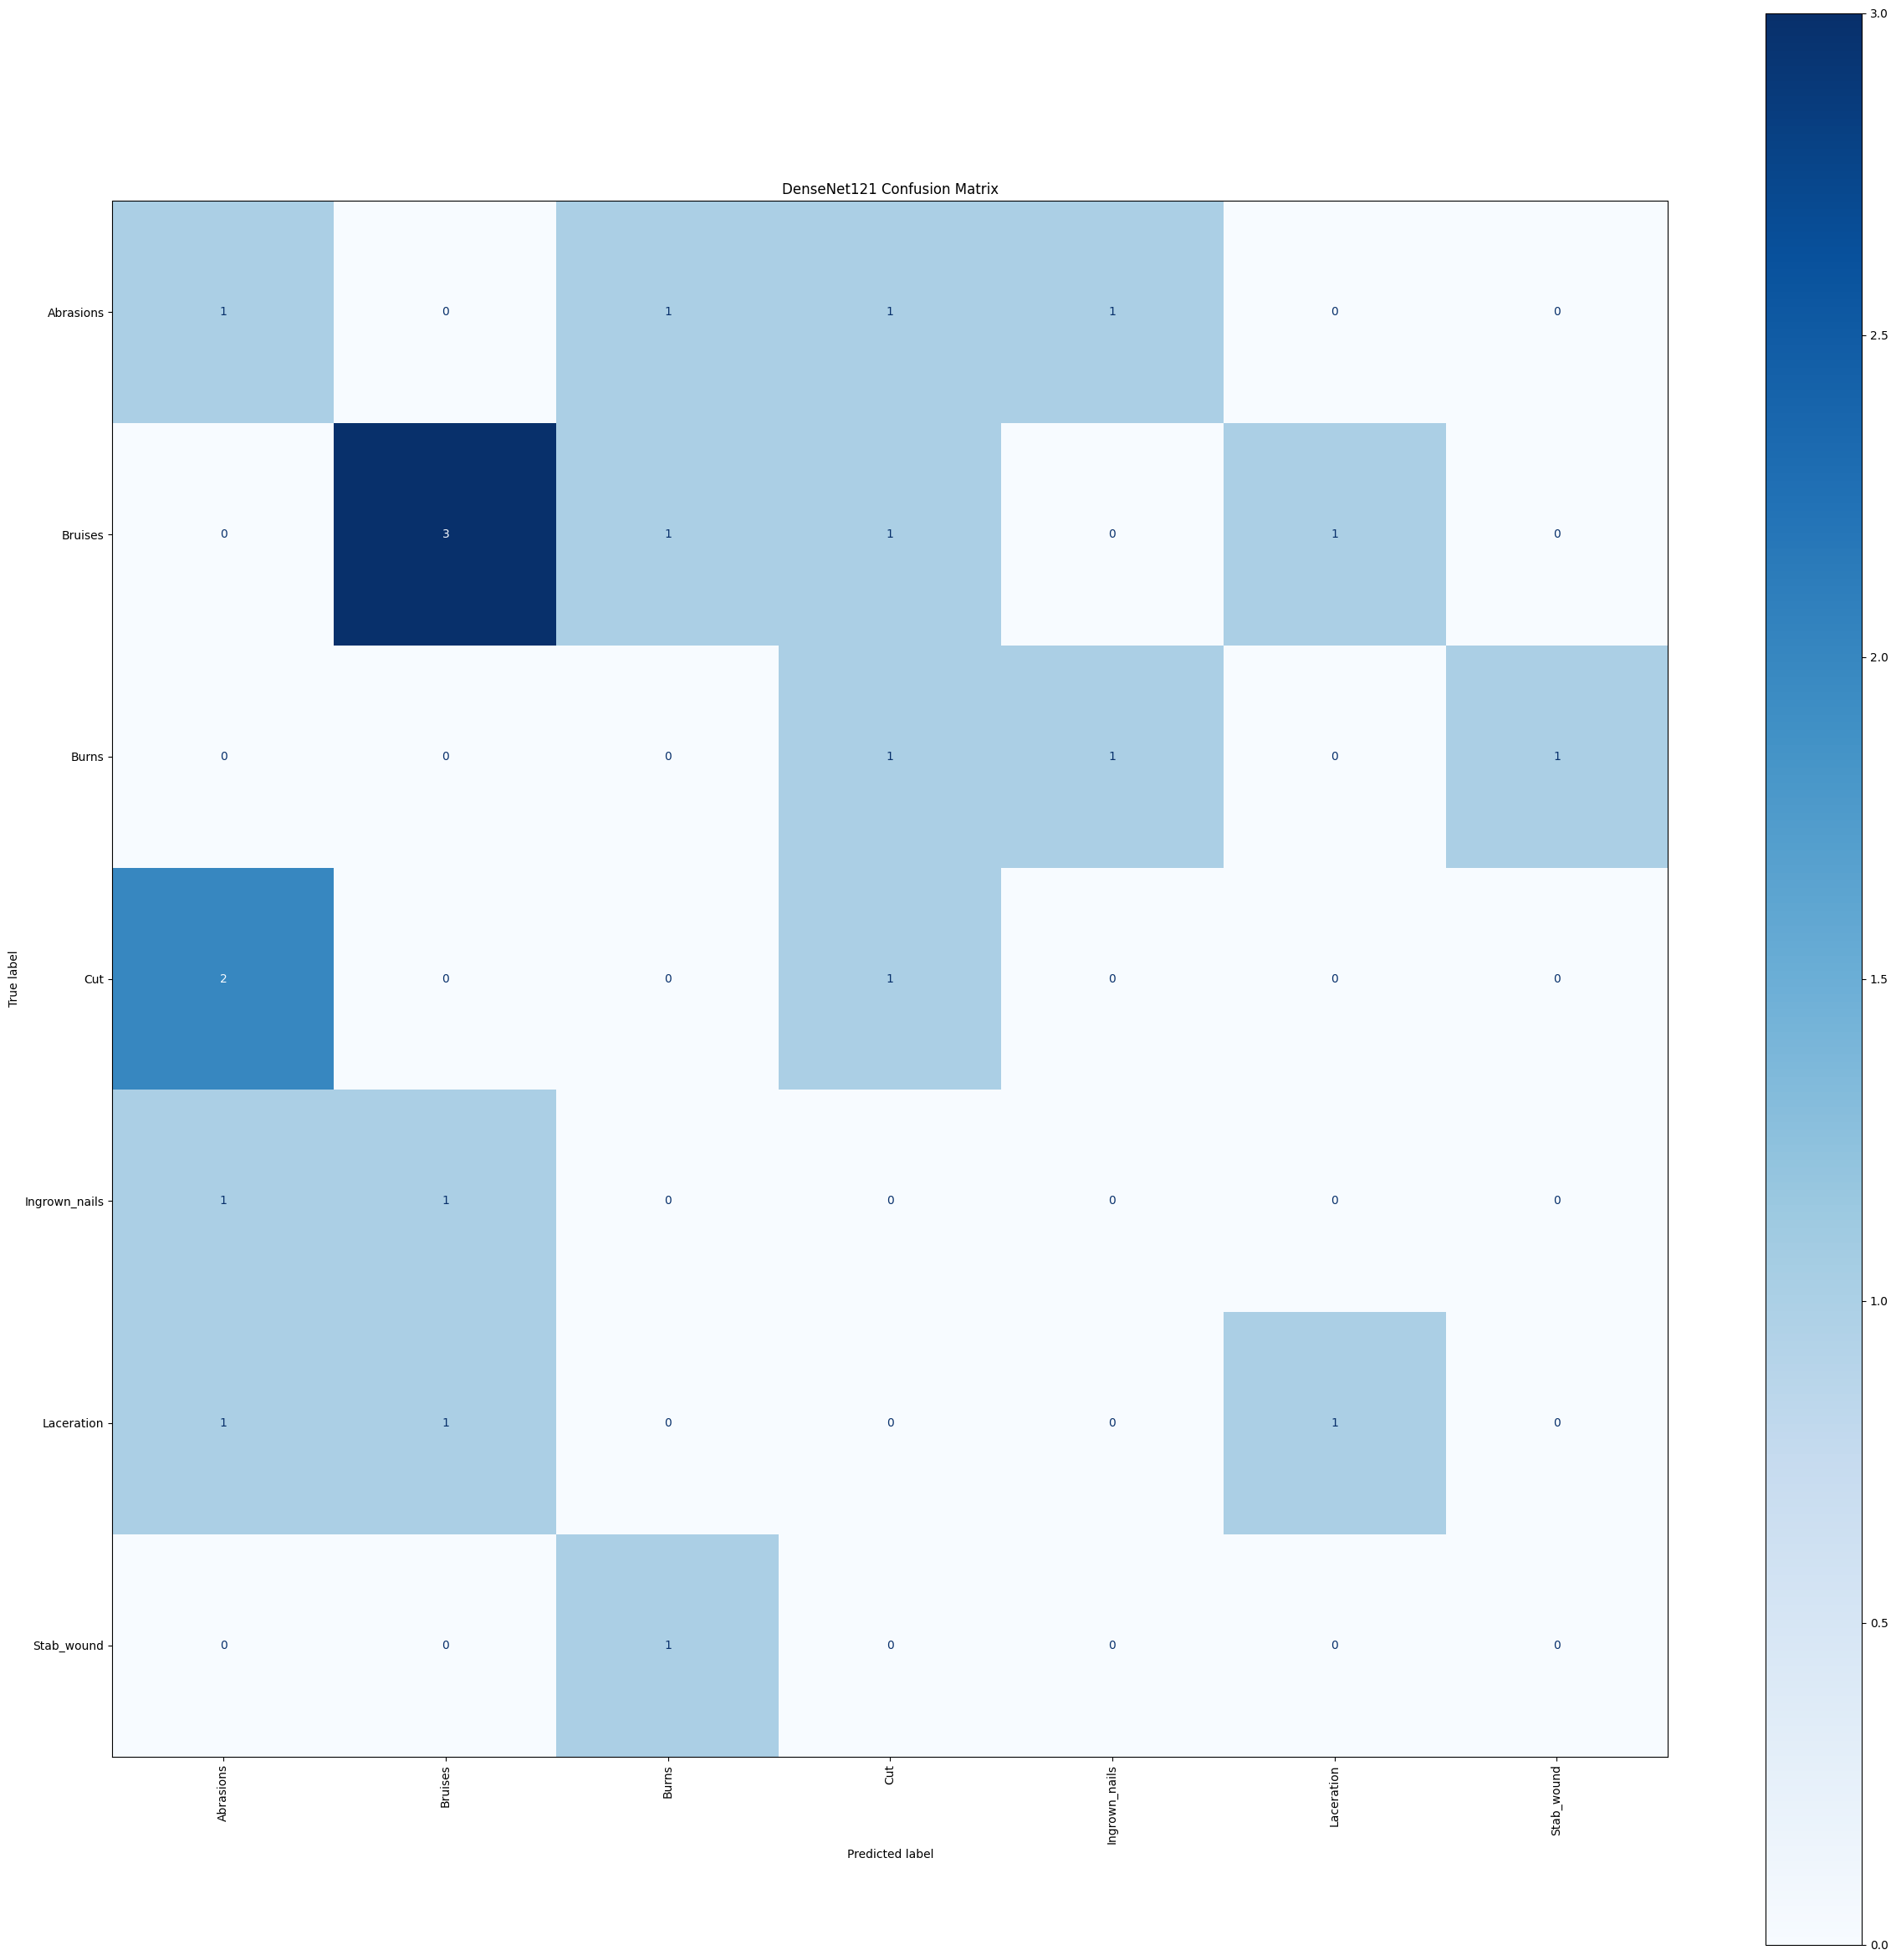

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


In [17]:
# List of base models with their respective input shapes
base_models5 = [
   (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet121')
]
model_training (base_models5)

# Testing and labeling unseen data

In [18]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image

# Load test dataset
test_df = pd.read_csv('/content/wound-dataset1/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file or "InceptionV3_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'Label': prediction_labels,
        })

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")

1/1 [==============================] - 4s 4s/step
Predictions saved to /content/saved_models/predicted_InceptionV3_saved.csv
1/1 [==============================] - 2s 2s/step
Predictions saved to /content/saved_models/predicted_ResNet50V2_saved.csv
1/1 [==============================] - 2s 2s/step
Predictions saved to /content/saved_models/predicted_MobileNetV2_saved.csv
1/1 [==============================] - 4s 4s/step
Predictions saved to /content/saved_models/predicted_DenseNet121_saved.csv
1/1 [==============================] - 3s 3s/step
Predictions saved to /content/saved_models/predicted_Xception_saved.csv


# image label and prediction and visualization

Predictions using: predicted_Xception_saved


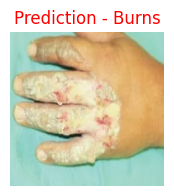

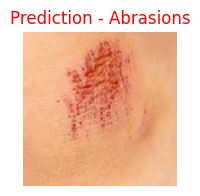

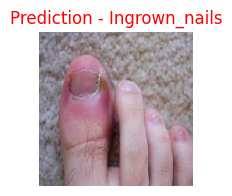

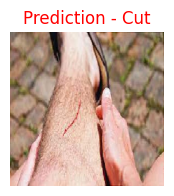

Predictions using: predicted_InceptionV3_saved


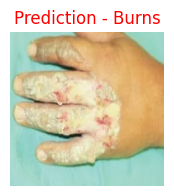

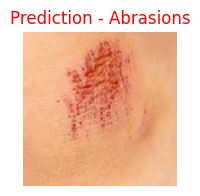

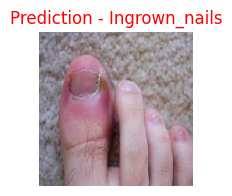

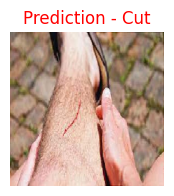

Predictions using: predicted_MobileNetV2_saved


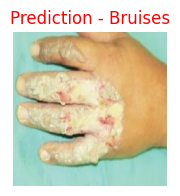

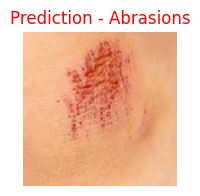

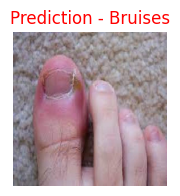

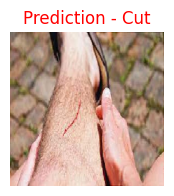

Predictions using: predicted_DenseNet121_saved


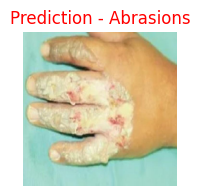

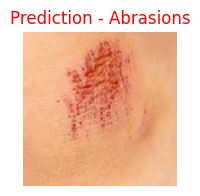

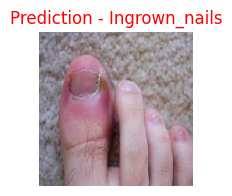

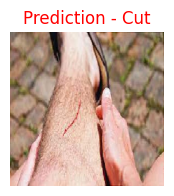

Predictions using: predicted_ResNet50V2_saved


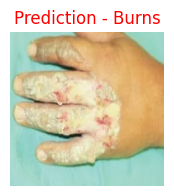

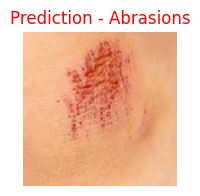

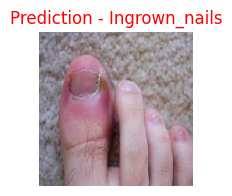

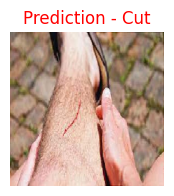

In [19]:
import csv
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/wound-dataset1/Wound_dataset/Burns/burns (33).jpg',
    '/content/wound-dataset1/Wound_dataset/Abrasions/abrasions (40).jpg',
    '/content/wound-dataset1/Wound_dataset/Ingrown_nails/ingrown_nail (18).jpg',
    '/content/wound-dataset1/Wound_dataset/Cut/cut (41).jpg'
]

def load_predicted_labels(csv_file_path):
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Label']
    return predicted_labels

def visualize_predictions(filenames, predicted_labels):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_name = predicted_labels[filename]
        else:
            print(f"Filename not found: {filename}")
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Directory containing the predicted CSV files
csv_dir = '/content/saved_models'

# Iterate over each CSV file in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):
        # Determine the model name
        model_name = csv_file.split('.')[0]

        # Path to the CSV file containing predictions for the current model
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        # Load predicted labels from the CSV file
        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Predict and plot images using predicted labels
        print(f"Predictions using: {model_name}")
        visualize_predictions(filenames, predicted_labels)
